# **Summary**
This notebook will fit a Random Forest model to predict the termination rate and find important factors that lead to termination.

- Can we predict who is going to terminate and who isn't? What level of accuracy can we achieve on this?

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, shapiro, levene
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, make_scorer,roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import mstats
from sklearn.feature_selection import RFE
from sklearn.tree import plot_tree

# display max columns
pd.set_option('display.max_columns', None)

# import data
model_df = pd.read_csv("model_HRDataset.csv")
df=pd.read_csv("cleaned_HRDataset.csv")

In [ ]:
model_df.head()

,MarriedID,MaritalStatusID,GenderID,DeptID,PerfScoreID,Salary,Termd,PositionID,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,Age,Tenure,DaysSinceLastReview
0,0,0,1,5,4,-0.197672,0,19,0.874608,1.000000,0.00000,0.0,0.693147,-0.500056,1.300076,0.532279
1,1,1,1,3,3,1.721067,1,27,0.987461,0.333333,1.94591,0.0,2.890372,0.406751,-1.742733,-1.479698
2,1,1,0,5,3,-0.054017,1,20,0.379310,0.333333,0.00000,0.0,1.386294,-1.066810,-1.739298,-1.317028
3,1,1,0,5,3,-0.051946,0,19,0.949843,1.000000,0.00000,0.0,2.772589,-1.066810,2.760213,0.652141
4,0,2,0,5,3,-0.970940,1,19,1.000000,0.666667,0.00000,0.0,1.098612,-1.180161,-0.093638,-0.580730


In [ ]:
df.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences,Age,Tenure,DiversityStatus,DeptAverageSalary,Salary_Dept_Ratio,DeptAveragePerfScore,PerformanceStandard,DaysSinceLastReview
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,0,19,Production Technician I,MA,1960,1983-07-10,M,Single,US Citizen,No,White,2011-07-05,NaN,Still Employed,Active,Production,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,2019-01-17,0,1,36,8.490075,Non-Diverse,59967.788462,1.042326,2.980769,1,348
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,1,27,Sr. DBA,MA,2148,1975-05-05,M,Married,US Citizen,No,White,2015-03-30,2016-06-16,Career Change,Voluntarily Terminated,IT/IS,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2016-02-24,0,17,44,1.215606,Non-Diverse,97064.640000,1.075953,3.060000,0,113
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,1,20,Production Technician II,MA,1810,1988-09-19,F,Married,US Citizen,No,White,2011-07-05,2012-09-24,Attendance,Voluntarily Terminated,Production,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,2012-05-15,0,3,31,1.223819,Non-Diverse,59967.788462,1.083165,2.980769,1,132
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,0,19,Production Technician I,MA,1886,1988-09-27,F,Married,US Citizen,No,White,2008-01-07,NaN,Still Employed,Active,Production,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,2019-01-03,0,15,31,11.980835,Non-Diverse,59967.788462,1.083765,2.980769,1,362
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,1,19,Production Technician I,MA,2169,1989-09-08,F,Divorced,US Citizen,No,White,2011-07-11,2016-09-06,Education,Voluntarily Terminated,Production,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2016-02-01,0,2,30,5.158111,Non-Diverse,59967.788462,0.847538,2.980769,1,218


In [ ]:
def model_metrics(preds, y):
    print(f'Accuracy: {accuracy_score(preds, y)}')
    print(f'Precision: {precision_score(preds, y)}')
    print(f'Recall: {recall_score(preds, y)}')
    print(f'F1: {f1_score(preds, y)}')
    print(f'ROC_AUC: {roc_auc_score(preds, y)}')

# **1. Fit RandomForest Model**

In [ ]:
X=model_df.drop('Termd', axis=1)
y=model_df['Termd']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# train RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# evaluate
y_pred = rf_model.predict(X_test)

# metrics
model_metrics(y_pred, y_test)

Accuracy: 0.9841269841269841
Precision: 0.9523809523809523
Recall: 1.0
F1: 0.975609756097561
ROC_AUC: 0.9883720930232558


# **2. Visualizations**

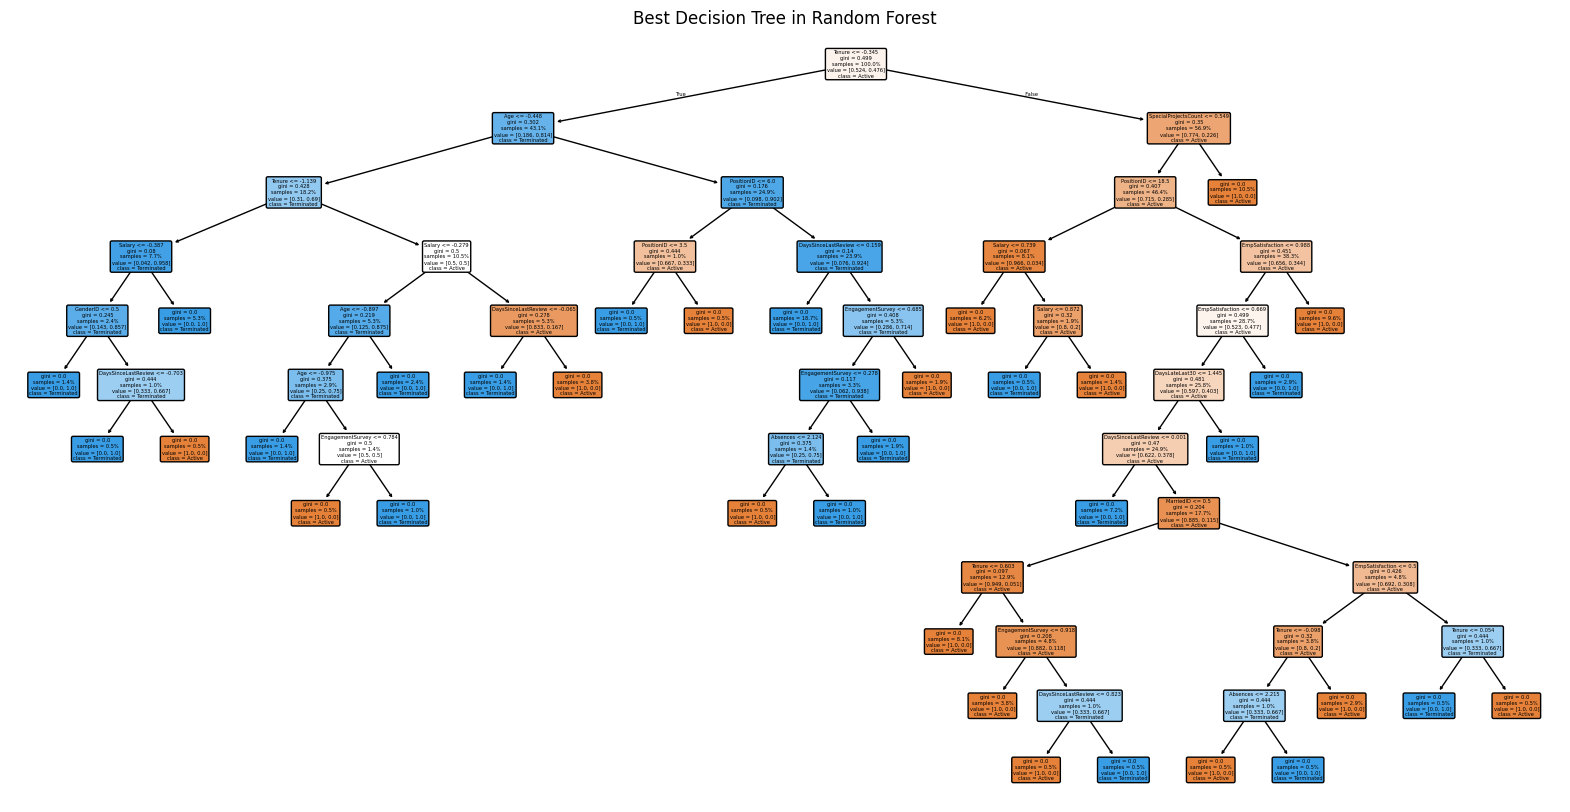

In [ ]:
tree_model = rf_model[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['Active', 'Terminated'], rounded=True, proportion=True)
plt.title("Best Decision Tree in Random Forest")
plt.show()

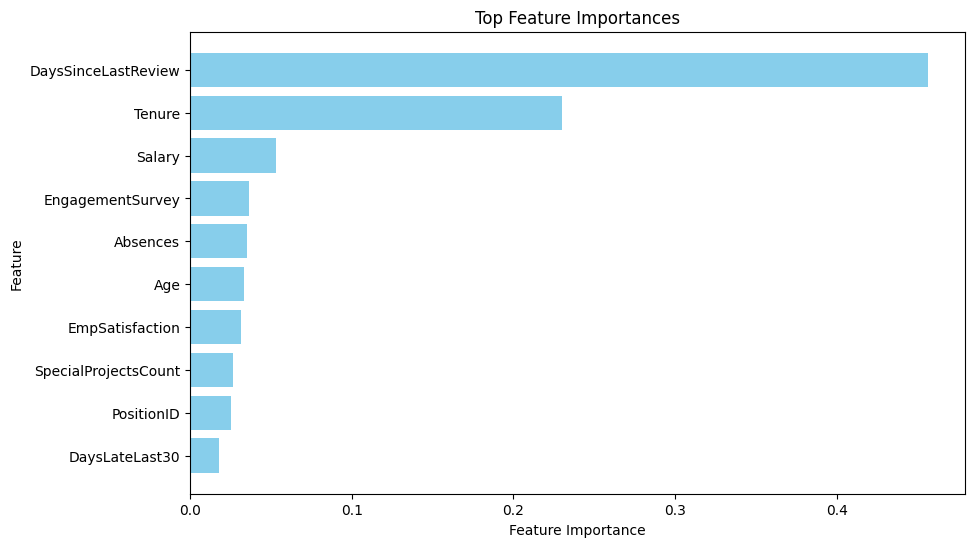

In [ ]:
def plot_feature_importance(model, feature_names, top_n=None):
    importances = model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    if top_n:
        importance_df = importance_df.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importance(rf_model, X.columns, top_n=10)

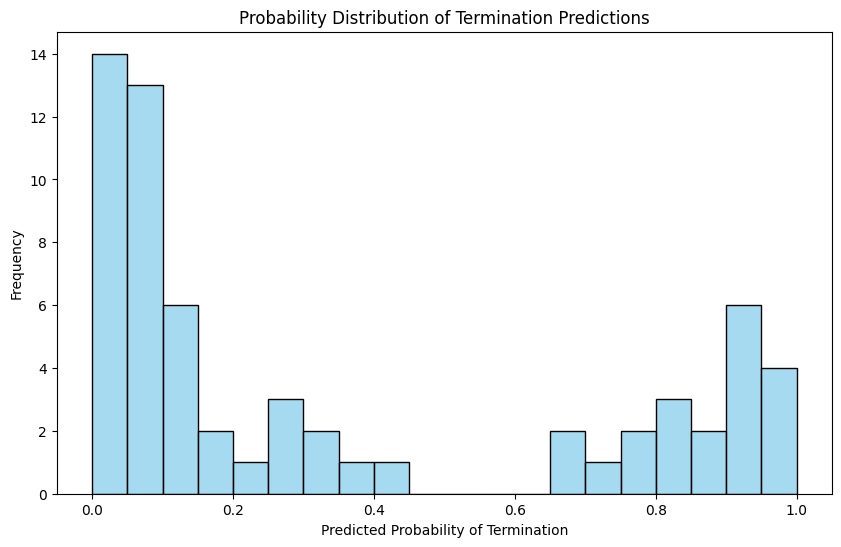

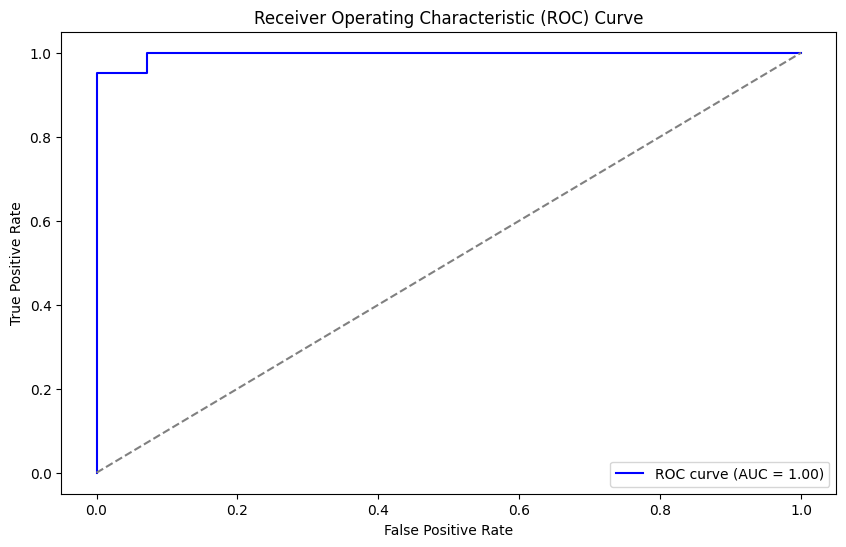

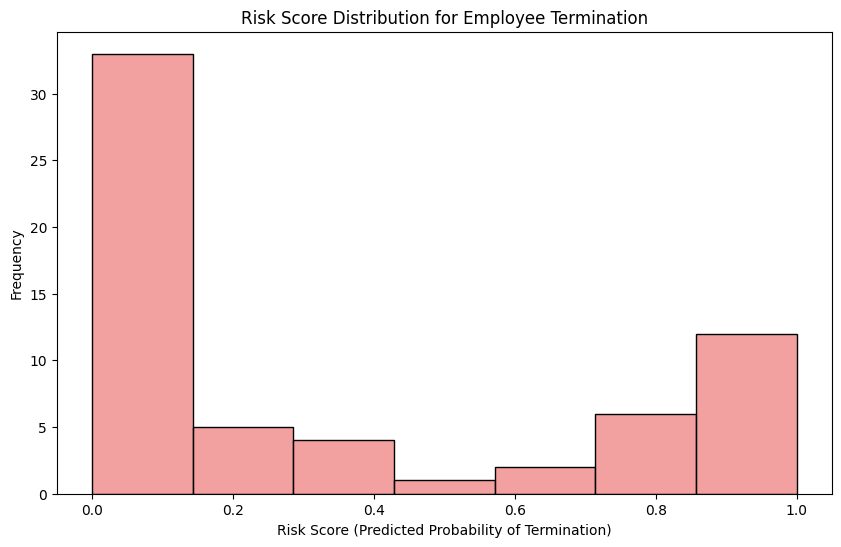

   Employee Index  Risk Score Risk Label
0             185        0.85  High Risk
1              34        0.02   Low Risk
2             310        0.07   Low Risk
3             139        0.03   Low Risk
4             150        0.11   Low Risk


In [ ]:
# get probabilities for the positive class (termination = 1)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# 1. Probabilistic Predictions Visualization (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(y_prob, bins=20, color='skyblue')
plt.title('Probability Distribution of Termination Predictions')
plt.xlabel('Predicted Probability of Termination')
plt.ylabel('Frequency')
plt.show()

# 2. ROC Curve for Model Evaluation
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 3. Risk Modeling: Create Risk Scores
# higher probabilities indicate higher risk of termination
risk_scores = y_prob

# binned risk categories (e.g., low, medium, high risk)
risk_labels = ['Low Risk' if score < 0.3 else 'Medium Risk' if score < 0.7 else 'High Risk' for score in risk_scores]

risk_df = pd.DataFrame({
    'Employee Index': X_test.index,
    'Risk Score': risk_scores,
    'Risk Label': risk_labels
})

# 4. Risk Scores Distribution
plt.figure(figsize=(10, 6))
sns.histplot(risk_scores, color='lightcoral')
plt.title('Risk Score Distribution for Employee Termination')
plt.xlabel('Risk Score (Predicted Probability of Termination)')
plt.ylabel('Frequency')
plt.show()

print(risk_df.head())

# **3. Conclusion**

Baseline metrics:
- Accuracy: 0.6507936507936508
- Precision: 0.22727272727272727
- Recall: 0.5
- F1: 0.3125
- ROC_AUC: 0.5896226415094341

Compared to the baseline metrics, the official Random Forest model has made considerable progress as a predictive model with the metrics:
- Accuracy: 0.9841269841269841
- Precision: 0.9523809523809523
- Recall: 1.0
- F1: 0.975609756097561
- ROC_AUC: 0.9883720930232558

Using the predictive power of the model a risk score was assigned to the employees to indicate if they were at risk of termination. The top factors of determining or prediecting termination status are:
- DaysSinceLastReview: The amount of days since the employee has had a performance review
- Tenure: The amount of time an employee has stayed active within in the company.
- Salary
- EngagementSurvey: The employee's satisfaction with the company.
- Age

